# Выпускной Проект: Анализ оттока клиентов в банке «Метанпром»
## Материалы

Презентация (https://disk.yandex.ru/i/Xz_1oqe2qPZoww)

Дашборд (https://public.tableau.com/views/_16857273533280/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

## Декомпозиция
Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Цель исследования** - Для отдела марркетинга банка:

Разобраться в причинах увеличения оттока в банке, выделить отточные сегменты, дать рекомендации по снижению оттока.

**Мое исследование пройдет в 7 этапов (задач):**

1. Обзор данных

Необходимо загрузить датасет и посмотреть на данные, дать комментарии по ним, что сразу видно нужно обработать и исправить.

2. Предобработка данных
- привести названия столбцов датасета к нижнему змеиному регистру
- проверить типы данных на соответстивие значениям
- проверить явные и неявные дубликаты
- анализ природы пропусков и их разумная обработка;
- кодирование (для использования в анализе корреляции).

3. EDA:
- анализ распределения признаков, в тч в разрезе оттока;
- анализ портретов клиентов в разрезе оттока;
- корреляционный анализ (в тч интерпретация).

4. Формулировка, обосноварие метода проверки и проверка статистических гипотез:
- Проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.
- В процессе исследования сформулировать вторую статистическую гипотезу для проверки.

5. Подведение промежуточных выводов
- Выводы по предыдущим пунктам
- выделение признаков влияющих на отток

6. Сегментация:
- выбирать неузкие сегменты
- обратить внимание чтобы отток у сегментов был лучше, чем средний уровень оттока по банку
- построить графики в разрезе признака, по которому ведется сегментация
- описать портрет получившихся сегментов

7. Выводы и рекомендации:
- приоритизация сегментов и формирование рекомендаций (не общих, а основанных на выводах)

## Работа над проектом

### Обзор данных

In [1]:
# импорт библиотек
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
pd.set_option('display.max_columns', 0)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib
from scipy import stats as st
! pip install phik
import phik

In [2]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
df = pd.read_csv(path)

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


**При первом взгляде на данные можно сказать, что:**

- есть пропущенные значения в датасете в столбцах age, balance
- название столбцов USERID, EST_SALARY в датасете необходимо привести к нижнему змеиному регистру
- столбец age в датасете можноо заменить тип на int64 для корректного отображения возраста, однако, пока не разберемся с пропусками в этом столбце, это сделать будет проблематично.

### Предобработка данных

**Заменим названия столбцов на змеиный регистр**

In [4]:
df = df.rename(columns={
    'USERID': 'user_id',
    'EST_SALARY': 'est_salary'
})
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


**Проверим дубликаты**

In [5]:
df.duplicated().sum()

0

Явных дубликатов нет, посмотрим что с неявными

In [6]:
df.duplicated(subset=['user_id']).sum()
print(len(df))
df = df.drop_duplicates(subset=['user_id'])
print(len(df))

10000
9927


Удалили неявные дубликаты.

**Работа с пропусками**

In [7]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
score,0.000000
city,0.000000
gender,0.000000
age,0.000000
equity,0.000000
balance,23.000000
products,0.000000
credit_card,0.000000
last_activity,0.000000


- В столбце age пропуски минимальны - можем ими принебречь и удалить их. 
- Столбец balance имеет классификацию MNAR — пропуски зависят от данных (скорее всего от возраста, семейного положения, количества недвижимости и т.п.), без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям. Поэтому столбец не будем трогать.

In [8]:
df = df.dropna(subset=['age']).reset_index(drop=True)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,9923.0,171731.481205,3.369437e+04,94561.0,142720.000,172635.00,201157.500,2.291450e+05
score,9923.0,848.732339,6.540011e+01,642.0,802.000,853.00,900.000,1.000000e+03
age,9923.0,42.729215,1.217701e+01,18.0,33.000,40.00,51.000,8.600000e+01
equity,9923.0,2.634284,1.979328e+00,0.0,0.000,3.00,4.000,9.000000e+00
balance,7663.0,828248.159829,1.984248e+06,0.0,295498.985,524961.22,980801.490,1.191136e+08
products,9923.0,1.871511,7.931103e-01,0.0,1.000,2.00,2.000,5.000000e+00
credit_card,9923.0,0.680036,4.664857e-01,0.0,0.000,1.00,1.000,1.000000e+00
last_activity,9923.0,0.523330,4.994806e-01,0.0,0.000,1.00,1.000,1.000000e+00
est_salary,9923.0,147886.494764,1.393639e+05,2546.3,75252.125,119719.33,174673.285,1.395064e+06
churn,9923.0,0.183311,3.869412e-01,0.0,0.000,0.00,0.000,1.000000e+00


In [10]:
df[(df['balance'].isna() == True)].describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2260.0,171975.568584,33277.188448,114182.00,143067.000,172498.50,201354.2500,229145.00
score,2260.0,865.334956,89.669447,642.00,871.000,903.00,922.0000,990.00
age,2260.0,42.125664,11.953138,18.00,33.000,40.00,49.0000,86.00
equity,2260.0,0.051770,0.227525,0.00,0.000,0.00,0.0000,3.00
balance,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products,2260.0,1.161504,0.401442,0.00,1.000,1.00,1.0000,3.00
credit_card,2260.0,0.815487,0.387988,0.00,1.000,1.00,1.0000,1.00
last_activity,2260.0,0.549115,0.497692,0.00,0.000,1.00,1.0000,1.00
est_salary,2260.0,226700.563111,199981.667262,20274.03,120457.015,174755.35,240451.8125,1333687.36
churn,2260.0,0.005752,0.075642,0.00,0.000,0.00,0.0000,1.00


В пропущенных данных в сравнении с общими данными по признаку баланс склонность к оттоку клиентов ниже.

In [11]:
df.corr()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
user_id,1.000000,0.009128,0.016432,0.004451,0.005697,-0.004377,0.004045,-0.031956,-0.000975,-0.010565
score,0.009128,1.000000,-0.011542,0.065586,0.235191,-0.003873,-0.095938,-0.030659,0.164474,0.106377
age,0.016432,-0.011542,1.000000,0.019764,0.070075,0.016862,-0.123113,-0.008697,-0.039372,-0.049763
equity,0.004451,0.065586,0.019764,1.000000,0.163711,0.431099,-0.167460,-0.001513,-0.171375,0.270195
balance,0.005697,0.235191,0.070075,0.163711,1.000000,0.075829,-0.059870,0.024767,0.338839,0.085698
products,-0.004377,-0.003873,0.016862,0.431099,0.075829,1.000000,-0.251698,0.038480,-0.117074,0.301393
credit_card,0.004045,-0.095938,-0.123113,-0.167460,-0.059870,-0.251698,1.000000,-0.033492,0.036183,-0.130649
last_activity,-0.031956,-0.030659,-0.008697,-0.001513,0.024767,0.038480,-0.033492,1.000000,0.002307,0.169514
est_salary,-0.000975,0.164474,-0.039372,-0.171375,0.338839,-0.117074,0.036183,0.002307,1.000000,0.001371
churn,-0.010565,0.106377,-0.049763,0.270195,0.085698,0.301393,-0.130649,0.169514,0.001371,1.000000


У столбца balance не найдено высоко коррелирующих признаков

Можно выдвинуть предположение о том, что пропуски в столбце balance датасета имеют случайное происхождение. 
  -  заполнение такого большого количества пропусков приведет к искажению распределения признака. 
  -  отвечая на главный вопрос нашего исследования мы выяснили, что в целом эти клиенты не склонны к оттоку. 

**Изменим тип данных в столбце age**

In [12]:
df['age'] = df['age'].astype('int')
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


**Кодирование (для использования в анализе корреляции)**

Закодируем данные в категориальных столбцах city, gender

In [13]:
df['city_one'] = df['city']
df['gender_one'] = df['gender']
df = pd.get_dummies(df, columns=['city_one'], drop_first=False)
df = pd.get_dummies(df, columns=['gender_one'], drop_first=True)
df

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_one_Ростов,city_one_Рыбинск,city_one_Ярославль,gender_one_М
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,0
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,0
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9918,120553,814.0,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0,0,1,0,1
9919,139170,894.0,Ярославль,М,46,0,NaN,1,1,0,196898.29,0,0,0,1,1
9920,115639,903.0,Ярославль,М,24,0,NaN,2,1,1,108905.09,0,0,0,1,1
9921,148700,777.0,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0,0,0,1,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9923 entries, 0 to 9922
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             9923 non-null   int64  
 1   score               9923 non-null   float64
 2   city                9923 non-null   object 
 3   gender              9923 non-null   object 
 4   age                 9923 non-null   int64  
 5   equity              9923 non-null   int64  
 6   balance             7663 non-null   float64
 7   products            9923 non-null   int64  
 8   credit_card         9923 non-null   int64  
 9   last_activity       9923 non-null   int64  
 10  est_salary          9923 non-null   float64
 11  churn               9923 non-null   int64  
 12  city_one_Ростов     9923 non-null   uint8  
 13  city_one_Рыбинск    9923 non-null   uint8  
 14  city_one_Ярославль  9923 non-null   uint8  
 15  gender_one_М        9923 non-null   uint8  
dtypes: flo

В результате предобработки:

- удалили пропущенные значения в датасете в столбце age, в столюце balance
- название столбцов USERID, EST_SALARY в датасете приведены к нижнему змеиному регистру
- столбец age в датасете заменен тип на int64 для корректного отображения возраста
- датасет проверен на явные и неявные дубликаты
- категориальные данные закодированы для использования в анализе корреляции

### EDA

**Анализ распределения признаков**

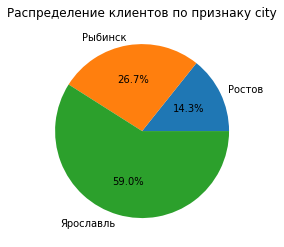

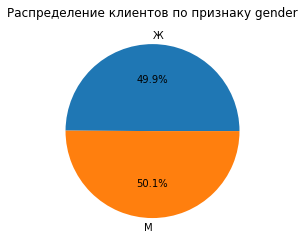

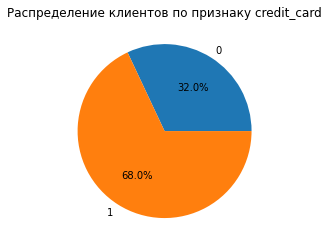

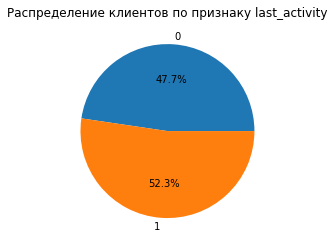

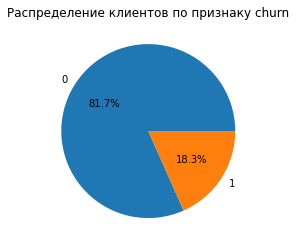

In [15]:
for column in ['city','gender','credit_card','last_activity','churn']:
    data = df.groupby(column).agg({'user_id': 'count'})
    fig1,ax1 = plt.subplots()
    ax1.pie(data['user_id'], labels=data.index, autopct='%1.1f%%')
    ax1.set_title(f'Распределение клиентов по признаку {column}')
    plt.show()

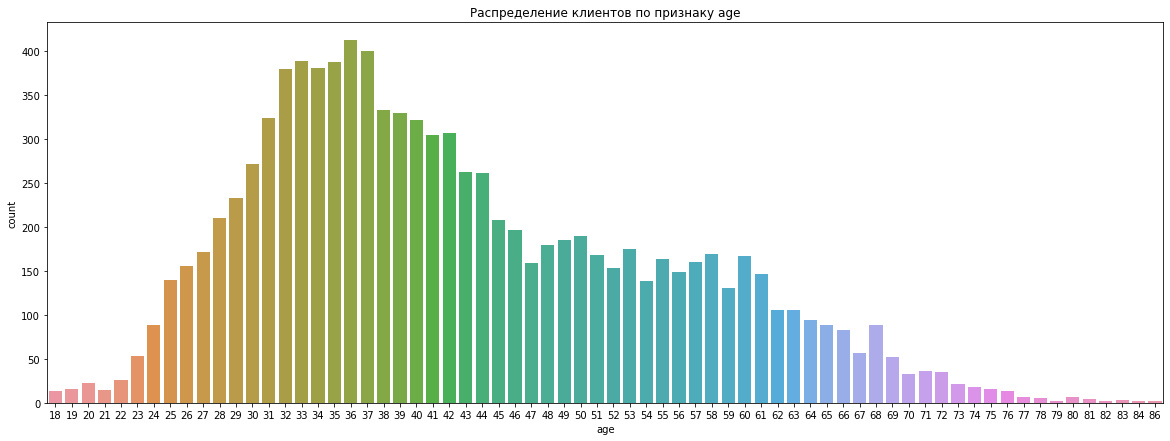

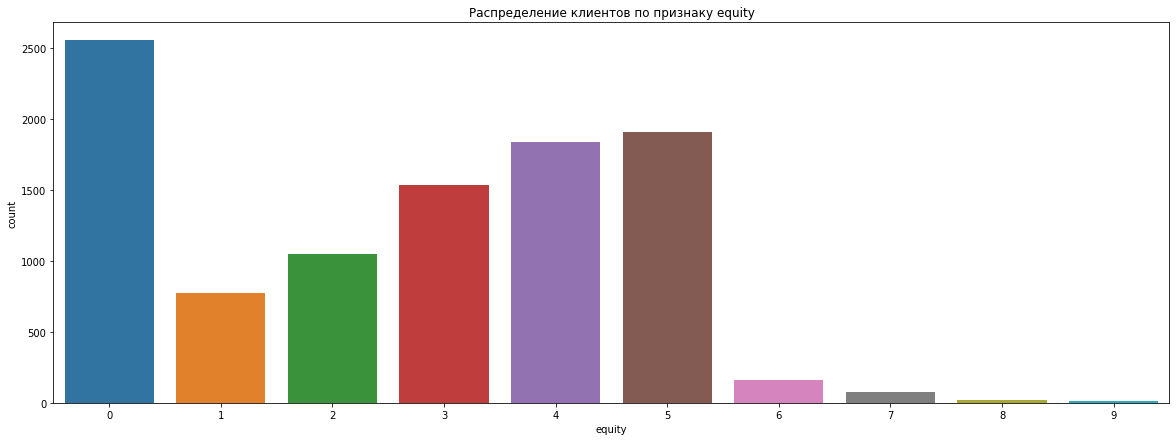

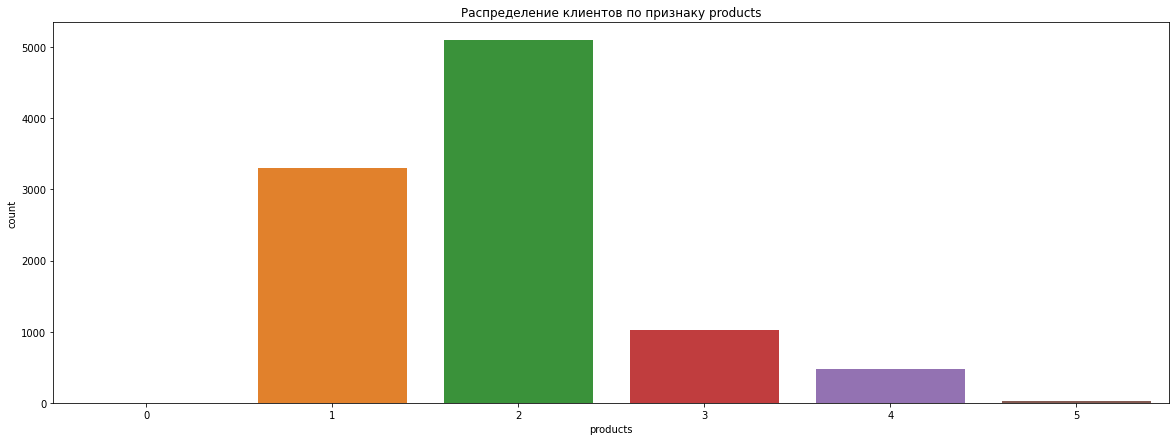

In [16]:
for column in ['age', 'equity', 'products']:
    plt.figure(figsize=(20,7))
    sns.countplot(df[column])
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.show()

In [17]:
df[(df['products']==0)]


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_one_Ростов,city_one_Рыбинск,city_one_Ярославль,gender_one_М
8901,147837,962.0,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,0,1,0,0


Клиентов с кличеством продуктов равным нулю -всего один чпеловек. Можно считать это аномальным значением и отбросить его.

In [18]:
df = df[(df['products']!=0)]


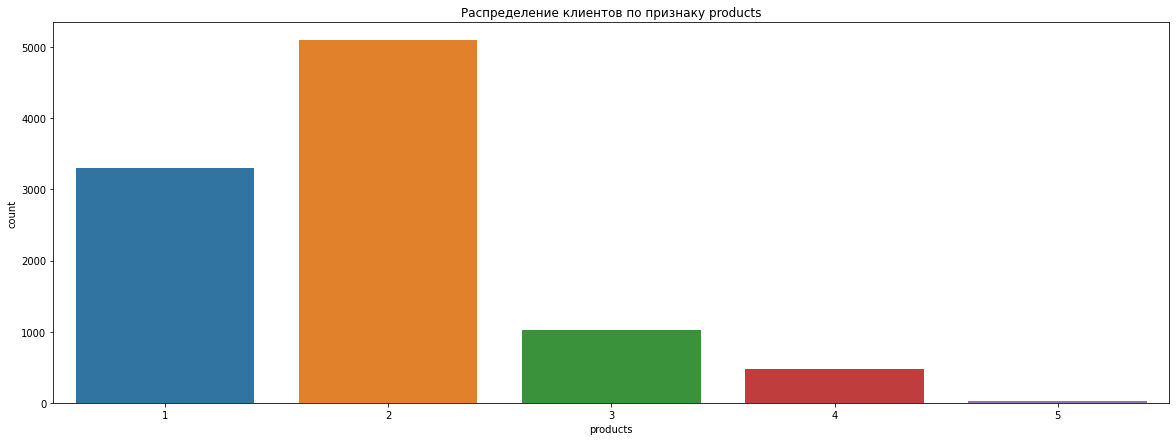

In [19]:
plt.figure(figsize=(20,7))
sns.countplot(df['products'])
plt.title('Распределение клиентов по признаку products')
plt.show()

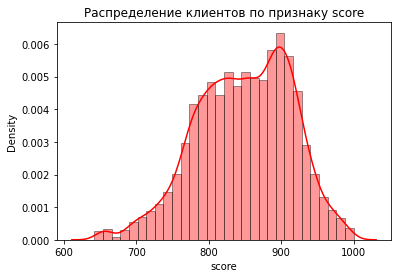

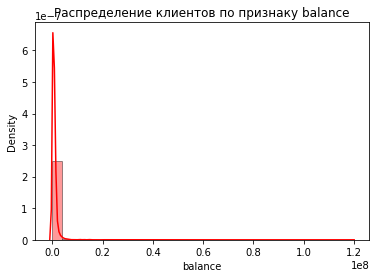

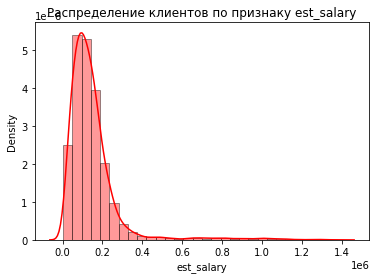

In [20]:
for column in ['score','balance','est_salary']:
    sns.distplot(df[column], hist=True,  bins=30, color = 'red', hist_kws={'edgecolor':'black'})
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.show()

При первичном исследовании данных можно сказать:
- Больше половины клиентов банка обслуживаются в г.Ярославль - 56%, в Рыбинске - 26% и Ростове по 14% клиентов. 
- Клиентов мужчин такое же количество, что и женщин ( что странно, возможно сделано специально для задания?)
- Кредитная карта есть у 68% клиентов
- 52% от общего числа клиентов являются активными
- Общий отток клиентов в банке составляет 18%
- Возраст клиентов имеет нормальное распределние, пик приходится на 30-45 лет
- От 1 до 5 объектов в собственности имеют примерно большинство клиентов. Самый большая доля клиентов не имеет ни одного объекта в собственности.
- Большая часть клиентов пользуются либо одним, либо двумя продуктами банка
- Большинство клиентов имеют кредитный рейтинг от 750 до 920. 
- Средний баланс клиентов банка до 100 т.р.
- Заработная плата клиентов в большинстве своем находится в диапозоне от 0 руб до 250 т.р. 

**Анализ распределения признаков в разрезе оттока**

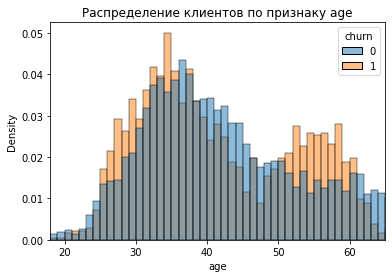

In [21]:
df_hist_age = df[['age','churn']]
sns.histplot(data = df_hist_age, x = 'age',  hue='churn',  stat="density", common_norm=False, binwidth=1)    
plt.xlim(left = np.nanpercentile(df['age'], 0), right=np.nanpercentile(df['age'], 95))
plt.title(f'Распределение клиентов по признаку age')    
plt.show()

Наиболее подвержены оттоку клиенты в возрасте от 25-32 лет и от 50-60 лет. Клиенты в возрасте от 60 лет и от 40 до 50 лет склонны к постоянству в выборе банка.

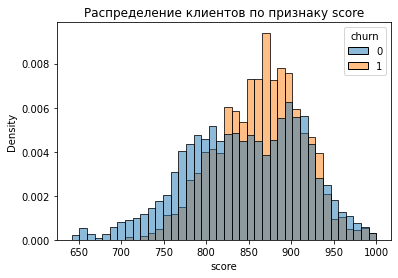

In [22]:
df_hist_score = df[['score','churn']]
sns.histplot(data = df_hist_score, x = 'score',  hue='churn',  stat="density", common_norm=False)
plt.title(f'Распределение клиентов по признаку score')    
plt.show()

Наиболее склонны к оттоку клиенты со скорингом от 825 до 900 баллов.

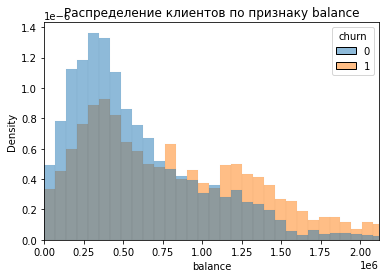

In [23]:
df_hist_balance = df[['balance','churn']]
sns.histplot(data = df_hist_balance, x = 'balance',  hue='churn',  stat="density", common_norm=False)    
plt.xlim(left = np.nanpercentile(df['balance'], 0), right=np.nanpercentile(df['balance'], 95))
plt.title(f'Распределение клиентов по признаку balance')    
plt.show()

Наиболее склонны к оттоку клиенты с балансом от 1,1 млн и выше.

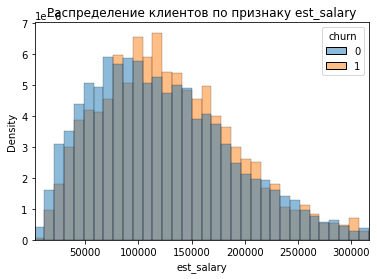

In [24]:
df_hist_est_salary = df[['est_salary','churn']]
sns.histplot(data = df_hist_est_salary, x = 'est_salary',  hue='churn',  stat="density", common_norm=False)    
plt.xlim(left = np.nanpercentile(df['est_salary'], 0), right=np.nanpercentile(df['est_salary'], 95))
plt.title(f'Распределение клиентов по признаку est_salary')    
plt.show()

Наиболее склонны к оттоку клиенты с зп от 100000 до 225000.

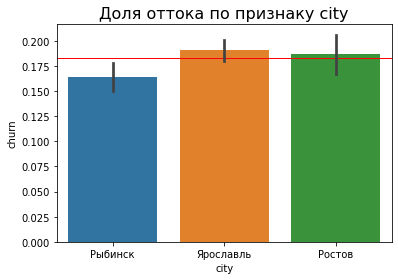

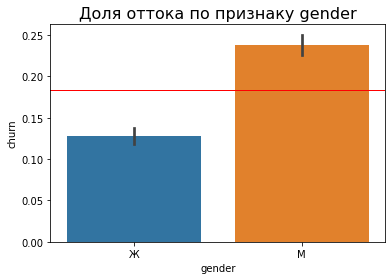

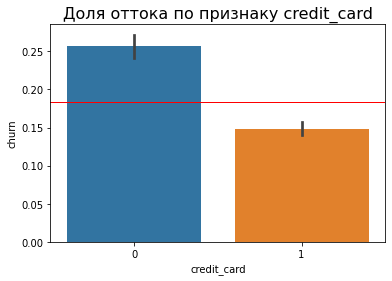

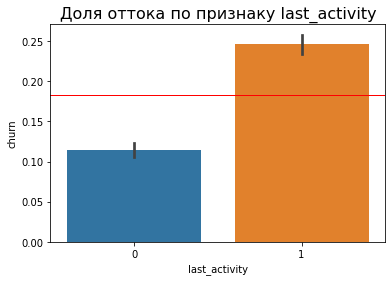

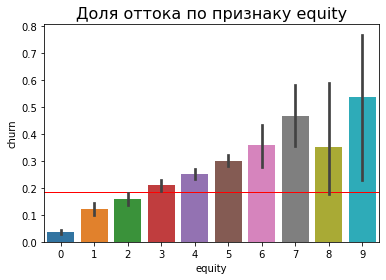

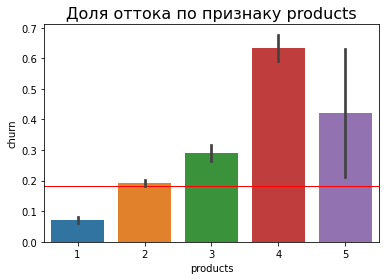

In [25]:
for column in ['city', 'gender', 'credit_card', 'last_activity', 'equity', 'products']:
        ax = sns.barplot(x=column, y='churn', data=df);
        plt.title(f'Доля оттока по признаку {column}', fontsize = 16, color = 'black')
        plt.axhline(y=np.nanmean(df.churn), linewidth=1, color='r',zorder=1)
        plt.show()   

- Больше всего клиентов ушло из филиала банка в Ярославле, меньше всего оттока в филиале банка в Рыбинске. 
- Чаще уходят мужчины, чем женщины
- Без кредитной карты доля оттока выше, чем с кредитной 
- Неактивные клиенты уходят реже, чем активные.
- Наибольший отток у клиентов с недвижимостью в количестве 7 и 9 единиц.
- Самые отточные клиенты с 4 продуктами

**Корреляционный анализ**

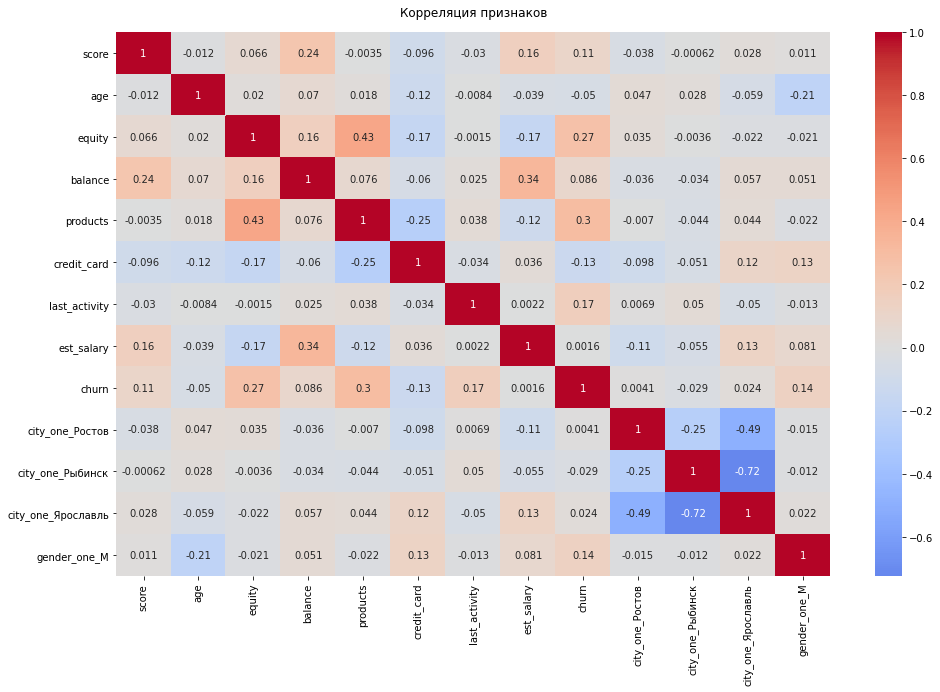

In [26]:
df_cor = df.drop(['user_id', 'city', 'gender'], axis=1)
plt.figure(figsize=(16, 10)) 
heatmap = sns.heatmap(df_cor.corr(), annot=True, cmap='coolwarm', center=0) 

heatmap.set_title('Корреляция признаков', fontdict={'fontsize':12}, pad=16);

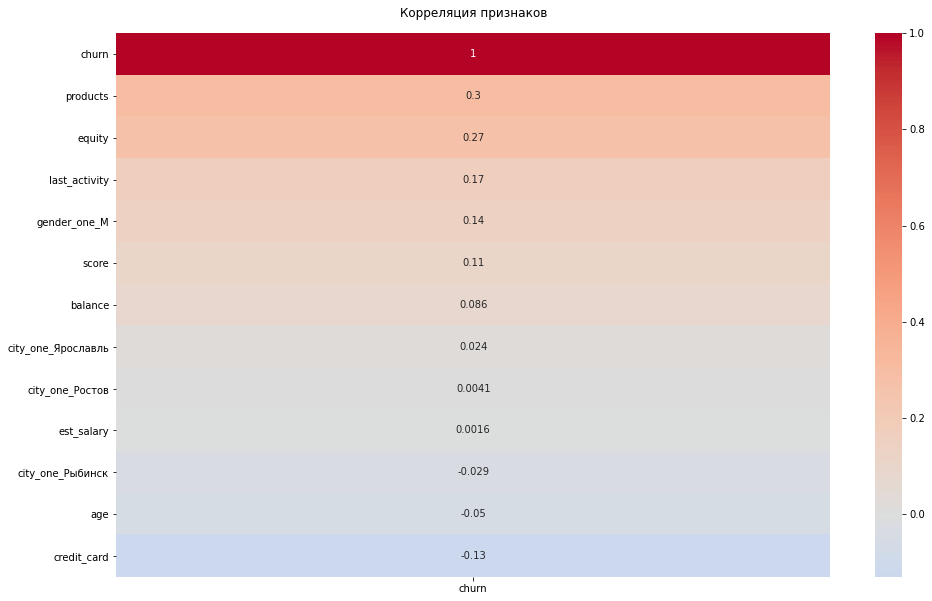

In [27]:
matrix = df_cor.corr()
matrix = matrix.loc[:, ['churn']].sort_values(by='churn', ascending=False)
plt.figure(figsize=(16, 10)) 
heatmap = sns.heatmap(matrix, annot=True, cmap='coolwarm', center=0) 

heatmap.set_title('Корреляция признаков', fontdict={'fontsize':12}, pad=16);

Сильной зависимости между признаками не наблюдается. Больше всего отток коррелирует с количеством продуктов у клиента и количеством имущества, зависимость по шкале Чеддока до 0,3 - слабая.

**Портрет клиента в разрезе оттока**

In [28]:
# создадим словарь для агрегирующей функции
agg_func = {
    'score': 'mean',
    'age': 'mean',
    'equity': 'median',
    'balance': 'mean',
    'products': 'median',
    'credit_card': lambda x: x.describe()[2],
    'last_activity': lambda x: x.describe()[2],
    'est_salary': 'mean',
    'city': lambda x: x.describe()[2],
    'gender': lambda x: x.describe()[2]
}

mean_churn = df.groupby('churn').agg(agg_func).round(2).T
mean_churn.columns=['remained', 'gone']
mean_churn

,remained,gone
score,845.44,863.36
age,43.02,41.43
equity,3,4
balance,733828.6,1134458.21
products,2,2
credit_card,0.45,0.5
last_activity,0.5,0.46
est_salary,147795.99,148357.48
city,Ярославль,Ярославль
gender,Ж,М


**Среднестатистический портрет клиента банка в разрезе оттока:**
- Средний рейтинг отточных клиентов и неооточных примерно одинаковый.
- Возраст: Наиболее подвержены оттоку клиенты в возрасте от 25-32 лет и от 50-60 лет. Клиенты в возрасте от 60 лет и от 40 до 50 лет склонны к постоянству в выборе банка.
- По количеству объектов собственности - - Наибольший отток у клиентов с недвижимостью в количестве 7 и 9 единиц.
- Наличие отстатков на балансе клиентов и подтвержденной зп существенно не влияет на отток, зависимости не прослеживаются. Однако, средний баланс отточных клиентов почти в два раза выше неооточных. Наиболее склонны к оттоку клиенты с зп от 100000 до 225000. Наиболее склонны к оттоку клиенты с балансом от 1,1 млн и выше.
- По количеству используемых продуктов - Самые отточные клиенты с 4 продуктами, с 1-им, 3-мя и 5-ти реже всего.
- Больше всего клиентов ушло из филиала банка в Ярославле, меньше всего оттока в филиале банка в Рыбинске. 
- Чаще уходят мужчины, чем женщины
- Без кредитной карты доля оттока выше, чем с кредитной 
- Неактивные клиенты уходят реже, чем активные.

### Формулировка, обосноварие метода проверки и проверка статистических гипотез

**Гипотеза 1. Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.**

Н_0: Средний доход клиентов, которые ушли из банка равен среднему доходу клиентов, которые остались

Н_1: Средний доход клиентов, которые ушли из банка не равен среднему доходу клиентов, которые остались

In [29]:
remained_clients = df[(df['churn']==0)]['est_salary']
gone_clients = df[(df['churn']==1)]['est_salary']
print('Количество сохраненных клиентов:',len(remained_clients))
print('Количество отточных клиентов:',len(gone_clients))

Количество сохраненных клиентов: 8104
Количество отточных клиентов: 1818


Text(0, 0.5, 'Количество клиентов')

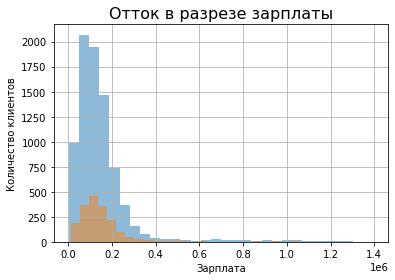

In [30]:
remained_clients.hist(bins = 30, alpha=0.5)
gone_clients.hist(bins = 30, alpha=0.5, label='churn');
plt.title(f'Отток в разрезе зарплаты', fontsize = 16, color = 'black')
plt.xlabel('Зарплата')
plt.ylabel('Количество клиентов');

Исследуемые выборки не зависимы друг от друга, распределение скошено влево с длинным правым хвостом. Это распределение Пуассона. Проверять гипотезу будем с помощью t-теста.

In [31]:
results = st.ttest_ind(remained_clients, gone_clients, equal_var=False)

alpha = 0.05

print(results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.8645271013531297
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу: разницы в средних доходах у клиентов, которые склонны к оттоку и нет, не наблюдается с большой долей вероятности.

**Гипотеза 2. Проверим гипотезу различия количества продуктов, которые есть у клиентов, между теми клиентами, которые ушли и теми, которые остались.**

Н-0: Среднее колличесво продуктов клиентов, ушедших в отток, равняется среднему количеству продуктов у клиентов, которые оствлись в банке.

Н_1: Среднее колличесво продуктов клиентов, ушедших в отток,  не равно среднему количеству продуктов у клиентов, которые оствлись в банке.

In [32]:
product_1 = df[(df['churn']==0)]['products']
product_2 = df[(df['churn']==1)]['products']

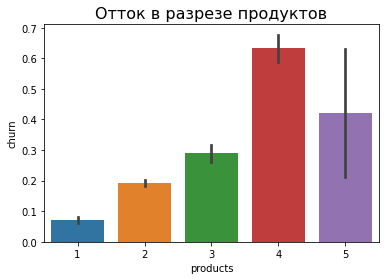

In [33]:
ax1 = sns.barplot(x='products', y='churn', data=df);
plt.title(f'Отток в разрезе продуктов', fontsize = 16, color = 'black')

plt.show()   


Благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности.

In [34]:
results = st.ttest_ind(product_1, product_2, equal_var=False)

alpha = 0.05

print(results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

8.186736545091533e-139
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу. Значит cреднее колличесво продуктов клиентов, ушедших в отток, не равно среднему количеству продуктов у клиентов, которые оствлись в банке, как мы и предполагали.

### Промежуточные выводы

**Среднестатистический портрет клиента банка в разрезе оттока:**
- Средний рейтинг отточных клиентов и неооточных примерно одинаковый.
- Возраст: Наиболее подвержены оттоку клиенты в возрасте от 25-32 лет и от 50-60 лет. Клиенты в возрасте от 60 лет и от 40 до 50 лет склонны к постоянству в выборе банка.
- По количеству объектов собственности - - Наибольший отток у клиентов с недвижимостью в количестве 7 и 9 единиц.
- Наличие отстатков на балансе клиентов и подтвержденной зп существенно не влияет на отток, зависимости не прослеживаются. Однако, средний баланс отточных клиентов почти в два раза выше неооточных. Наиболее склонны к оттоку клиенты с зп от 100000 до 225000. Наиболее склонны к оттоку клиенты с балансом от 1,1 млн и выше.
- По количеству используемых продуктов - Самые отточные клиенты с 4 продуктами, с 1-им, 3-мя и 5-ти реже всего.
- Больше всего клиентов ушло из филиала банка в Ярославле, меньше всего оттока в филиале банка в Рыбинске. 
- Чаще уходят мужчины, чем женщины
- Без кредитной карты доля оттока выше, чем с кредитной 
- Неактивные клиенты уходят реже, чем активные.

**Гипотеза 1. Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.**
Не получилось отвергнуть нулевую гипотезу: разницы в средних доходах у клиентов, которые склонны к оттоку и нет, не наблюдается с большой долей вероятности.

**Гипотеза 2. Проверим гипотезу различия количества продуктов, которые есть у клиентов (1 продукт и 2 продукта), между теми клиентами, которые ушли и теми, которые остались.**
Среднее колличесво продуктов клиентов, ушедших в отток, не равно среднему количеству продуктов у клиентов, которые оствлись в банке

### Сегментация

По результатам работы в прошлых блоках, выделим несколько высокоотточных сегментов пользователей. Доля оттока в них должна превышать среднюю по банку - 18,2%

В качестве критериев для выделения выберем следующие параметры:

мужской пол;
возраст 40-60 лет;
количество используемых продуктов;
Количество объектов в собственности;
город филлиала,
наличие КК,
активность клиента.

**Сегмент №1**

- Пол: мужской
- Возраст: от 25-32 лет

In [35]:
# Рассчитаем общее число пользователей в этом сегменте:
seg1 = df.query (
    'gender_one_М == 1 and age >= 25 and age <= 32')['user_id'].count() 
print ('Общее число пользователей в сегменте №1:', seg1)


# Рассчитаем число отточных пользователей в этом сегменте:
gone_seg1_count = df.query (
    'gender_one_М == 1 and age >= 25 and age <= 32 and churn==1')['user_id'].count()
print ('Число отточных пользователей в сегменте №1:', gone_seg1_count)

#  Рассчитаем долю отточных пользователей:
gone_seg1_share = gone_seg1_count / seg1 * 100
print ('Доля отточных пользователей в сегменте №1:', gone_seg1_share)

Общее число пользователей в сегменте №1: 1108
Число отточных пользователей в сегменте №1: 297
Доля отточных пользователей в сегменте №1: 26.805054151624546


**Сегмент №2**

- Пол: все
- Баланс больше - 1,1 млн

In [36]:
# Рассчитаем общее число пользователей в этом сегменте:
seg2 = df.query (
    'balance >= 1100000')['user_id'].count() 
print ('Общее число пользователей в сегменте №2:', seg2)


# Рассчитаем число отточных пользователей в этом сегменте:
gone_seg2_count = df.query (
    'balance >= 1100000 and churn==1')['user_id'].count()
print ('Число отточных пользователей в сегменте №2:', gone_seg2_count)

#  Рассчитаем долю отточных пользователей:
gone_seg2_share = gone_seg2_count / seg2 * 100
print ('Доля отточных пользователей в сегменте №2:', gone_seg2_share)

Общее число пользователей в сегменте №2: 1609
Число отточных пользователей в сегменте №2: 663
Доля отточных пользователей в сегменте №2: 41.20571783716594


**Сегмент №3**

- Пол: все
- Возраст: все
- Город: все
- Количество продуктов - 4 шт

In [37]:
# Рассчитаем общее число пользователей в этом сегменте:
seg3 = df.query (
    'products == 4')['user_id'].count() 
print ('Общее число пользователей в сегменте №3:', seg3)


# Рассчитаем число отточных пользователей в этом сегменте:
gone_seg3_count = df.query (
    'products == 4 and churn==1')['user_id'].count()
print ('Число отточных пользователей в сегменте №3:', gone_seg3_count)

#  Рассчитаем долю отточных пользователей:
gone_seg3_share = gone_seg3_count / seg3 * 100
print ('Доля отточных пользователей в сегменте №3:', gone_seg3_share)

Общее число пользователей в сегменте №3: 474
Число отточных пользователей в сегменте №3: 300
Доля отточных пользователей в сегменте №3: 63.29113924050633


### Общий вывод

**Итоговые выводы**

**Параметры, влияющим на отток:**

- Средний рейтинг отточных клиентов и неооточных примерно одинаковый.
- Возраст: Наиболее подвержены оттоку клиенты в возрасте от 25-32 лет и от 50-60 лет. Клиенты в возрасте от 60 лет и от 40 до 50 лет склонны к постоянству в выборе банка.
- По количеству объектов собственности - - Наибольший отток у клиентов с недвижимостью в количестве 7 и 9 единиц.
- Наличие отстатков на балансе клиентов и подтвержденной зп существенно не влияет на отток, зависимости не прослеживаются. Однако, средний баланс отточных клиентов почти в два раза выше неооточных. Наиболее склонны к оттоку клиенты с зп от 100000 до 225000. Наиболее склонны к оттоку клиенты с балансом от 1,1 млн и выше.
- По количеству используемых продуктов - Самые отточные клиенты с 4 продуктами, с 1-им, 3-мя и 5-ти реже всего.
- Больше всего клиентов ушло из филиала банка в Ярославле, меньше всего оттока в филиале банка в Рыбинске.
- Чаще уходят мужчины, чем женщины
- Без кредитной карты доля оттока выше, чем с кредитной
- Неактивные клиенты уходят реже, чем активные.
**Был проведен статистический анализ следующих гипотез:**
Гипотеза 1. О различии дохода между теми клиентами, которые ушли и теми, которые остались. Не подтвердилась
Гипотеза №2 О различии количества продуктов, которые есть у клиентов (1 продукт и 2 продукта), между теми клиентами, которые ушли и теми, которые остались. Подтвердилась


**Были выделены сегменты, в наибольшей степени подверженных оттоку (от 25 до 63 % отточных клиентов)**

**Приоритизация сегментов и рекомендации для отдела маркетинга**

### Расположим сегменты в порядке убывания доли отточных клиентов:

Наиболее высокая доля отточных клиентов в сегменте **№3 - почти 63%** отточных клиентов

- Пол: все
- Возраст: все
- Город: все
- Количество продуктов - 4 шт

**Рекомендации:**
- Посмотреть, что не так с сегментом клиентов имеющих 4 продукта (мб это продукты не значительны для клиента и не дают понимание, что этот банк является основным для него)
- Предложить выгодные условия по долгосрочным продуктам (кредитованию, ипотеке)
- Увеличить проникновение кредитных карт в данный сегмент, Предложить специальные условия по КК(например, бесплатное годовое обслуживание, увеличение льготного периода или льготная %ставка);


Далее сегмент **№2 - 41%** отточных клиентов
- Пол: все
- Баланс больше - 1,1 млн

**Рекомендации:**
- Посмотреть на работу премиальных менеджеров банка, так как это сегмент средне-состоятельных и состоятельных клиентов.
- Проанализировать условия по депозитным и инвестиционным условиям банка и предложениям для клиентов по ним. Возможно в других банках предложения лучше и клиенты уходят к конкурентам.
- Сделать предложения по ипотеки для таких клиентов, чтобы вложить данные средства в неджижимость и оставить клиента в банке на долгое время.


На третьем месте **сегмент №1 - более 26%** оттока
Пол: мужской
Возраст: от 25-32 лет

**Рекомендации:**
- Увеличить активность клиентов данного сегмента
- Запустить акцию по транзакционной активности с призом для победителей;
- Настроить автоплатеж в мобильном приложении за телефон или коммунальные услуги
- Выгодные условия по кешбеку соответствующие категориям интересов клиентов этого возраста.
- Предложение долгосрочных креждитных и инвестиционных продуктов.